# Image classification for vehicle body type

### Summary

The goal is to recognize a body type for a vehicle in order to infer a CO2 emission


## Libraries

In [1]:
# Utils
import sys
import os
import shutil
import time
import pickle
import numpy as np

# Deep Learning Librairies
import tensorflow as tf
import tensorflow.keras.preprocessing.image as kpi
import tensorflow.keras.layers as kl
import tensorflow.keras.optimizers as ko
import tensorflow.keras.backend as k
import tensorflow.keras.models as km
import tensorflow.keras.applications as ka

# Data visualization
from matplotlib import pyplot as plt

from tensorflow.python.client import device_lib
MODE = "GPU" if "GPU" in [k.device_type for k in device_lib.list_local_devices()] else "CPU"
print(MODE)

CPU


## Dataset

The dataset used in this TP is the build from a scraper we crated.
Each subdirectory of `data/vehicle_images` represents a body type to recognize


### Dataset organisation

To use some of the image generators of keras, that we will used later, we have to organise the dataset so that each data of a same class are within the same folder. 

Our data are then organized this way :

```
data
└───vehicle_images/
│   └───train/
│   │   └───berline/
│   │   │   │   0001.jpg
│   │   │   │   0002.jpg
│   │   │   │   ...
│   │   └───break/
│   │   │   │   0001.jpg
│   │   │   │   0002.jpg
│   │   │   │   ...
│   └───validation/
│   │   └───berline/
│   │   │   │   0001.jpg
│   │   │   │   0002.jpg
│   │   │   │   ...
│   │   └───break/
│   │   │   │   0001.jpg
│   │   │   │   0002.jpg
│   │   │   │   ...
```

###  Parameter

In [2]:
path_data = '../data/vehicle_images' # data path
path_data_train = path_data + '/train'
path_data_val = path_data + '/val'

car_body_types = ['berline', 'break', 'cabriolet', 'combispace', 'coupe', 'minibus', 'minispace', 'monospace', 'monospace compact', 'tous-terrains']

### Illustration of the data

The `load_img` function allows to load an image as a PIL image.

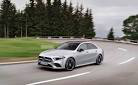

In [3]:
img = kpi.load_img(path_data_train + '/berline/0001.jpg')  # this is a PIL image
img

The function `img_to_array` generates an `array numpy` from a  PIL image.

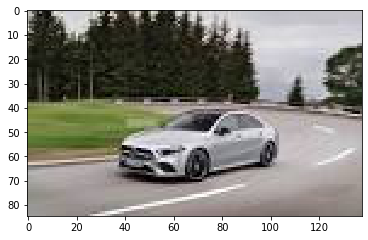

In [4]:
x = kpi.img_to_array(img)  
plt.imshow(x/255, interpolation='nearest')
plt.show()

## Pre-processing

The `ImageDataGenerator` `keras`function allows to apply different treatments on the images (transformation, normalisation). This  transformation allows to increase the size of the dataset and to make the classifier more robust.

All the possible transformations are listed in the documentation of the function.

In [5]:
datagen = kpi.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

The`.flow()` command generates transformed images from an original image and saves its in the specified directory.

In the following code we produce 8 of these transformed images.

In [6]:
path_preprocessing_ex = path_data + "/preprocessing_example"
img = kpi.load_img(path_data_train + '/berline/0001.jpg')  # this is a PIL image
x = kpi.img_to_array(img)
x_ = np.expand_dims(x, axis=0)

if not(os.path.isdir(path_preprocessing_ex)):
    os.mkdir(path_preprocessing_ex)

    i = 0
    for batch in datagen.flow(x_, batch_size=1, save_to_dir=path_preprocessing_ex, save_prefix='berline', save_format='jpeg'):
        i += 1
        if i > 7:
            break

Display transformed images

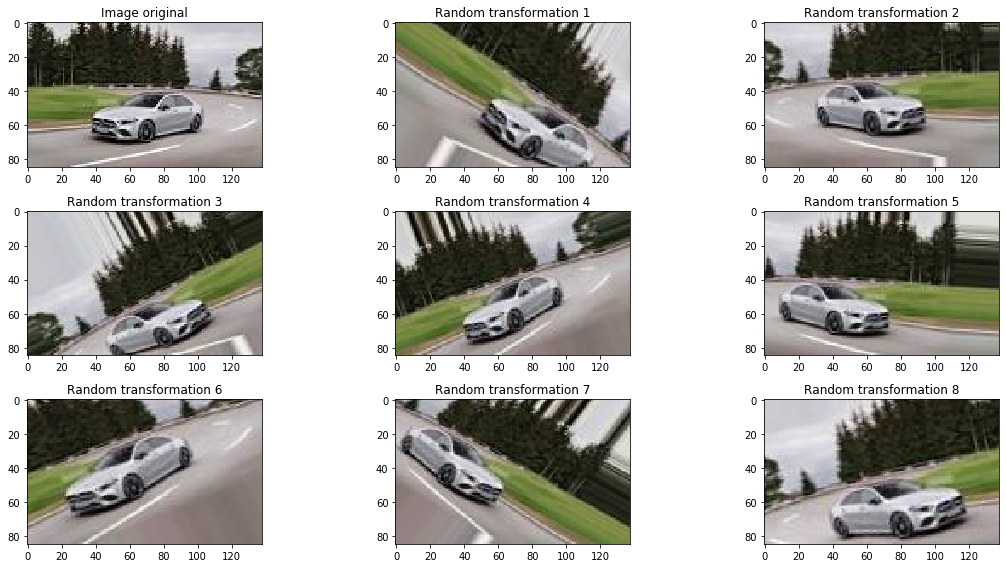

In [7]:
X_list = []
for f in os.listdir(path_preprocessing_ex):
    X_list.append(kpi.img_to_array(kpi.load_img(path_preprocessing_ex + '/' + f)))


fig = plt.figure(figsize=(16, 8))
fig.patch.set_alpha(0)
ax = fig.add_subplot(3, 3, 1)
ax.imshow(x/255, interpolation="nearest")
ax.set_title("Image original")
for i, xt in enumerate(X_list):
    ax = fig.add_subplot(3, 3, i+2)
    ax.imshow(xt/255, interpolation="nearest")
    ax.set_title("Random transformation %d" % (i+1))
plt.tight_layout()
plt.savefig("cars_transformation.png", dpi=100, bbox_to_anchor="tight", facecolor=fig.get_facecolor())
plt.show()

## Image classification from scratch with a convolutional network

We will here build a classifier with a custom architecture of a convolutional network.

We first define epochs and batch_size parameters.

* `epochs`: we start with a small number (5-10) in order to check that computing time is reasonable.
* `batch_size`:When using keras Generator, size of the batch should be a divider of the size of the sample, otherwise algorithms produce very unstable results.


In [8]:
epochs = 10
batch_size=20

### Data Generation

We defined two `ImageDataGenerator` objects :

* `train_datagen`: for learning, where different transformations are applied as above, in order to pass various examples to the model.
* `valid_datagen`: for validation, where only rescaling is applied.

Images have different dimensions :

In [9]:
car_body_type = car_body_types[0]
x_0 = kpi.img_to_array(kpi.load_img(path_data_train + '/' + car_body_type + "/0001.jpg"))
x_1 = kpi.img_to_array(kpi.load_img(path_data_train + '/' +  car_body_type + "/0002.jpg"))
x_0.shape, x_1.shape

((85, 138, 3), (84, 150, 3))

which is annoying because all images must have the same dimension to be used in this network. 

The `flow_from_directory` method allows to specify an output dimension in which all transformed images will be produced.

In [10]:
img_width = 150
img_height = 150

In [11]:
# prepare data augmentation configuration
train_datagen = kpi.ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = kpi.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    path_data_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    path_data_val,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 1407 images belonging to 10 classes.
Found 439 images belonging to 10 classes.


### Model architecture

The model we define is composed of 3 convolution blocks with the following form : 

* A Conv2D layer with 32-3X3 filters and a `Relu` activation function.
* A MaxPooling layer with 2X2 window.

Followed by 


* A flatten layer.
* A Dense layer with 64 neurons and a Relu activation function.
* A Dropout layer with a 50% drop rate.
* A Dense layer with 1 neuron and a softmax activation function.

In [21]:
model_conv = km.Sequential()
model_conv.add(kl.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), data_format="channels_last"))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Conv2D(32, (3, 3)))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Conv2D(64, (3, 3)))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_conv.add(kl.Dense(64))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.Dropout(0.5))
model_conv.add(kl.Dense(1))
model_conv.add(kl.Activation('sigmoid'))

model_conv.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

As our problem here is a two classes classifier we will use the `binary_crossentropy` loss function.

#### Training

The training can then be done by using the `fit_generator` function instead of the `fit` function used in the MNIST notebook. This function can be used by passing generator object instead of the data to the function

In [13]:
# N_train = 200
# N_val = 80
N_train = 800
N_val = 320

In [22]:
ts = time.time()
model_conv.fit_generator(train_generator, steps_per_epoch=N_train // batch_size, epochs=epochs,
                         validation_data=validation_generator, validation_steps=N_val // batch_size)
te = time.time()
t_learning_conv_simple_model = te-ts
print("Learning Time for %d epochs : %d seconds" % (epochs, t_learning_conv_simple_model))

Epoch 1/10
10/10 [==============================] - 6s 612ms/step - loss: -16619.2528 - acc: 0.1000 - val_loss: -85346.6982 - val_acc: 0.0750
Epoch 2/10
10/10 [==============================] - 3s 320ms/step - loss: -520475.0641 - acc: 0.0750 - val_loss: -1175053.1406 - val_acc: 0.0750
Epoch 3/10
10/10 [==============================] - 3s 318ms/step - loss: -2466217.1375 - acc: 0.1050 - val_loss: -4327787.5000 - val_acc: 0.0750
Epoch 4/10
10/10 [==============================] - 4s 384ms/step - loss: -7542977.0000 - acc: 0.1000 - val_loss: -11629356.6250 - val_acc: 0.0750
Epoch 5/10
10/10 [==============================] - 3s 332ms/step - loss: -18985904.8000 - acc: 0.0800 - val_loss: -24798857.7500 - val_acc: 0.0750
Epoch 6/10
10/10 [==============================] - 4s 373ms/step - loss: -39850943.4000 - acc: 0.1200 - val_loss: -46983785.0000 - val_acc: 0.0750
Epoch 7/10
10/10 [==============================] - 3s 256ms/step - loss: -63362896.8158 - acc: 0.1390 - val_loss: -76011707

#### Prediction

In [23]:
ts = time.time()
score_conv_val = model_conv.evaluate_generator(validation_generator, N_val /batch_size, verbose=1)
score_conv_train = model_conv.evaluate_generator(train_generator, N_train / batch_size, verbose=1)
te = time.time()
t_prediction_conv_simple_model = te-ts
print('Train accuracy:', score_conv_train[1])
print('Validation accuracy:', score_conv_val[1])
print("Time Prediction: %.2f seconds" %t_prediction_conv_simple_model )

10/10 [==============================] - 1s 111ms/step - loss: -258698128.0000 - acc: 0.0900
Train accuracy: 0.09
Validation accuracy: 0.075
Time Prediction: 1.49 seconds


## Pre-trained Network

We have seen above that the complexity of the data makes it difficult to build quickly an efficient classifier from scratch even  with an elaborate method as a convolutional network.

We will now see that this problem can easily be tackled by using **pre-trained models**. These models are models that are very complex (see image below). They have been trained on a very huge amount of image data in order to classify them. 

The figure below represents a *VGG 16*. This model is composed of *5 convolutional blocks* which allows to build features on the images. The last block is a *fully convolutional block*. This last block can be seen as a simple *MLP model* which is used on the features build by the convolutional block.

How this model, designed to solve a different problem that our problem can be helpfull?

Here is our two-stage strategy :  
1. We will send our data through the 5 convolutional block in order to build features. These block have been trained on a huge amount of data and can then build intelligent features.
2. We will build our own MLP classifier designed to solve our CatsVsDogs problem, and we will train it on the features built on the first step.

### Step 1 : Build features

#### Download  the weights of the 5 blocks convolutional layer.

We will now download the weights of a VGG16 model that has been learned on the [image-net](http://www.image-net.org) dataset. The image-net is composed of millions of images for 1000 categories.

If it's the first time you use these weights, you will have to download it (it will start automatically) and they will be save in your home 
`"~/.keras/models"`

The *include_top* argument of the `VGG16` application allows to precise if we want to use or not the last block (fully-connected later)


In [17]:
model_VGG16_without_top = ka.InceptionV3(include_top=False, weights='imagenet')

# model_VGG16_without_top.summary()

#### Building features

We will now send our data to the loaded model in order to build our features.

In [18]:
N_train = 200
N_val = 80
# N_train = 800
# N_val = 320

In [19]:
datagen = kpi.ImageDataGenerator(rescale=1. / 255)

generator = datagen.flow_from_directory(
        path_data_train,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        shuffle=False)  
features_train = model_VGG16_without_top.predict_generator(generator, N_train / batch_size,  verbose = 1)


generator = datagen.flow_from_directory(
    path_data_val,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
features_validation = model_VGG16_without_top.predict_generator(generator, N_val / batch_size,  verbose = 1)    

Found 1407 images belonging to 10 classes.
10/10 [==============================] - 7s 707ms/step
Found 439 images belonging to 10 classes.
4/4 [==============================] - 2s 429ms/step


### Step 2 :  Building our classifier on top of features

We will now build a simple classifier in order to use the previously build features to classify our data.


#### Training
**Exercise** Write this classifier 

In [24]:
# %load solutions/classifier_pretrained_model.py
model_VGG_fcm = km.Sequential()
model_VGG_fcm.add(kl.Flatten(input_shape=features_train.shape[1:]))
model_VGG_fcm.add(kl.Dense(64, activation='relu'))
model_VGG_fcm.add(kl.Dropout(0.5))
model_VGG_fcm.add(kl.Dense(1, activation='sigmoid'))

model_VGG_fcm.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

model_VGG_fcm.summary()


train_labels = np.array([0] * int((N_train/2)) + [1] * int((N_train/2)))
validation_labels = np.array([0] * int((N_val/2)) + [1] * int((N_val/2)))

te = time.time()
model_VGG_fcm.fit(features_train, train_labels,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=(features_validation, validation_labels))

ts = time.time()
t_learning_VGG_fcm = te-ts

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                1179712   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 1,179,777
Trainable params: 1,179,777
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 80 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/sample - loss: 13.7237 - acc: 0.4650 - val_loss: 0.8885 - val_acc: 0.5375
Epoch 2/10
200/200 [==============================] - 0s 569us

We now save the weights of this classifier to be used later.

### Prediction

In [32]:
def evaluation(model, features_train, train_labels, features_validation, validation_labels):
    ts = time.time()
    score_train = model.evaluate(features_train, train_labels)
    score_val = model.evaluate(features_validation, validation_labels)
    te = time.time()
    t_prediction_fcm = te-ts
    print('Train accuracy:', score_train[1])
    print('Validation accuracy:', score_val[1])
    print("Time Prediction: %.2f seconds" %t_prediction_fcm)
    
    return score_train[1], score_val[1], t_prediction_fcm

In [ ]:
evaluation(model_VGG_fcm, features_train, train_labels, features_validation, validation_labels)

In [26]:
model_VGG_fcm.save_weights(path_data + '/weights_model_VGG_fully_connected_model_%d_epochs_%d_batch_size.h5' %(epochs, batch_size))

### Models comparison

In [35]:
N_train = 800
N_val = 320

models_pretrained = [ka.InceptionV3, ka.DenseNet121, ka.DenseNet169, ka.DenseNet201,
                     ka.InceptionResNetV2, ka.ResNet50V2, ka.ResNet101V2, ka.ResNet152V2, ka.VGG16, ka.Xception]
histories = []
models_accuracy_train = []
models_accuracy_val = []
models_time_train = []
models_time_pred = []
model_name = []

for m in models_pretrained:
    # model instanciation
    model_pretrained_without_top = m(include_top=False, weights='imagenet')
    
    # data generator
    datagen = kpi.ImageDataGenerator(rescale=1./255)

    generator_train = datagen.flow_from_directory(
        path_data_train,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        shuffle=False)
    features_train = model_pretrained_without_top.predict_generator(generator_train, N_train / batch_size, verbose=1)

    generator_val = datagen.flow_from_directory(
        path_data_val,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    features_validation = model_pretrained_without_top.predict_generator(generator_val, N_val / batch_size, verbose=1)
    

    print("\n\n##################################")
    print("modèle utilisé : ", model_pretrained_without_top.name)
    print("##################################\n\n")

    # model training
    model_top = km.Sequential()
    model_top.add(kl.Flatten(input_shape=features_train.shape[1:]))
    model_top.add(kl.Dense(64, activation='relu'))
    model_top.add(kl.Dropout(0.5))
    model_top.add(kl.Dense(1, activation='sigmoid'))

    model_top.compile(optimizer='rmsprop',
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

    train_labels = np.array([0] * int((N_train/2)) + [1] * int((N_train/2)))
    validation_labels = np.array([0] * int((N_val/2)) + [1] * int((N_val/2)))

    model_top.fit(features_train, train_labels,
                         epochs=epochs,
                         batch_size=batch_size,
                         validation_data=(features_validation, validation_labels))
    
    t_learning_fcm = te-ts
    print("Time training: %.2f seconds" % t_learning_fcm)
    
    score_train, score_val, t_prediction_fcm = evaluation(model_top, features_train, train_labels, features_validation, validation_labels)

    models_name.append(model_pretrained_without_top.name)
    histories.append(model_top.history)
    models_time_train.append(t_learning_fcm)
    models_time_pred.append(t_prediction_fcm)
    models_accuracy_train.append(score_train)
    models_accuracy_val.append(score_val)

Found 1407 images belonging to 10 classes.
40/40 [==============================] - 24s 589ms/step
Found 439 images belonging to 10 classes.
16/16 [==============================] - 6s 351ms/step


##################################
modèle utilisé :  inception_v3
##################################


Train on 800 samples, validate on 320 samples
Epoch 1/10
800/800 [==============================] - 12s 15ms/sample - loss: 3.3843 - acc: 0.5400 - val_loss: 0.6356 - val_acc: 0.6344
Epoch 2/10
800/800 [==============================] - 1s 1ms/sample - loss: 0.7423 - acc: 0.6012 - val_loss: 0.6341 - val_acc: 0.6094
Epoch 3/10
800/800 [==============================] - 1s 1ms/sample - loss: 0.6755 - acc: 0.6100 - val_loss: 0.5911 - val_acc: 0.6719
Epoch 4/10
800/800 [==============================] - 1s 1ms/sample - loss: 0.6485 - acc: 0.6475 - val_loss: 0.5894 - val_acc: 0.7000
Epoch 5/10
800/800 [==============================] - 1s 1ms/sample - loss: 0.6268 - acc: 0.6525 - val_loss: 0.6365

In [ ]:
plt.plot(models_name, models_accuracy_val)

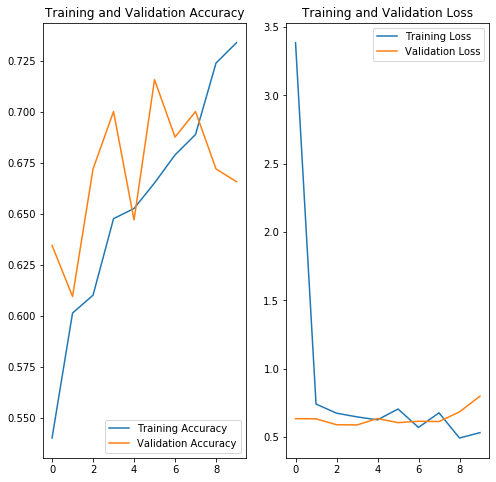

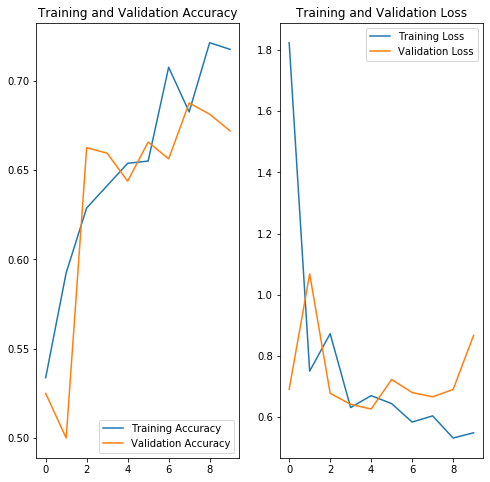

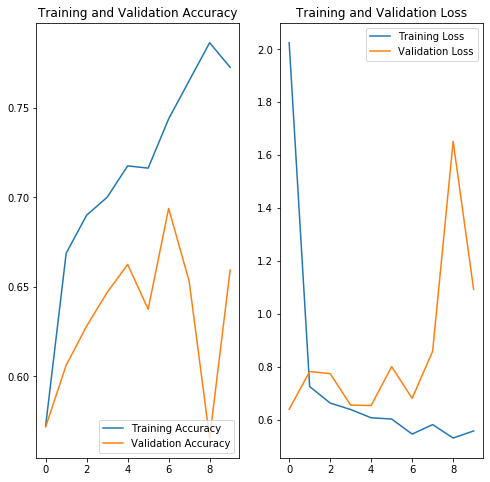

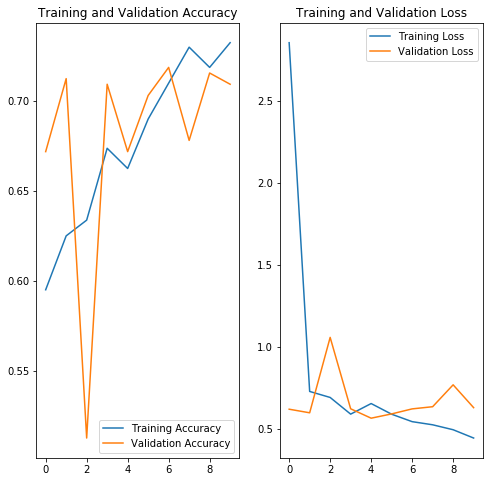

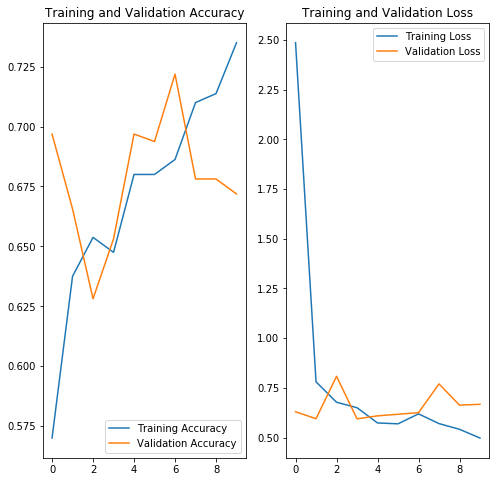

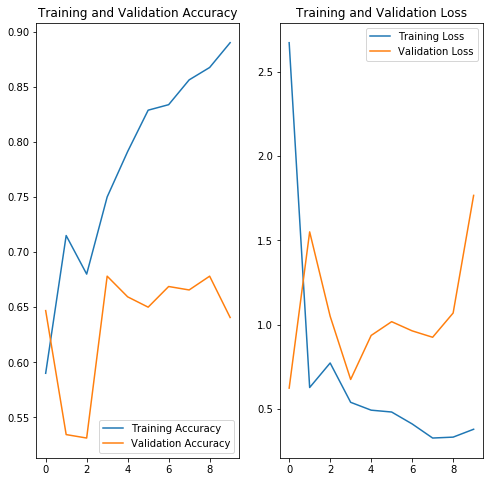

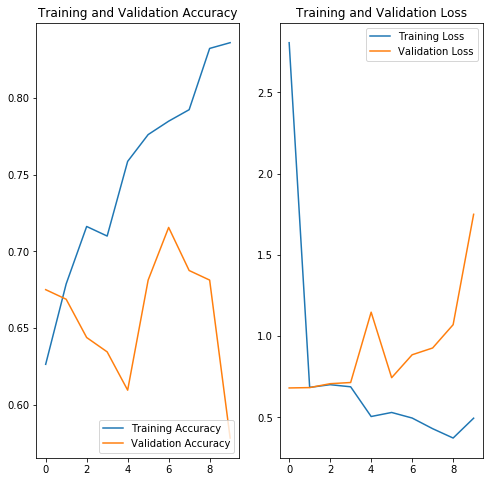

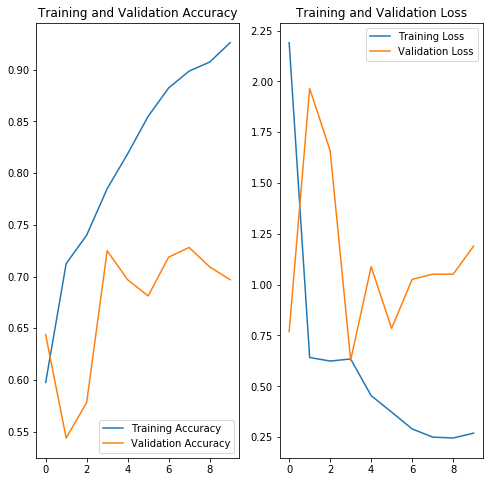

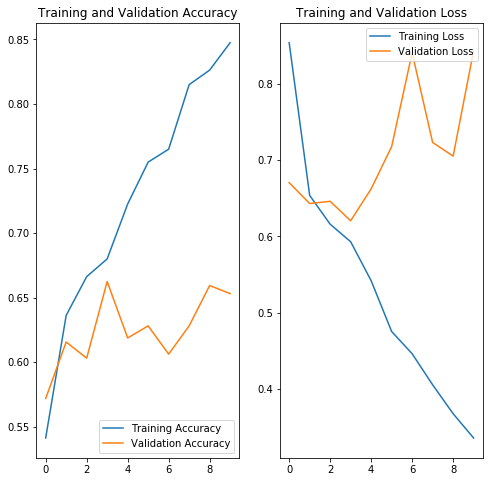

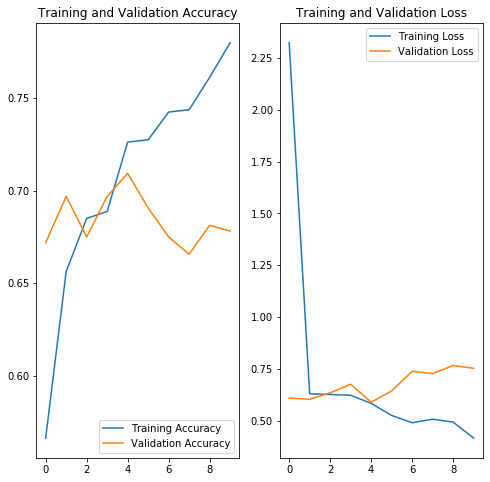

In [43]:
for i, history in enumerate(histories):
#     print ("modèle : ", models_name[i])

    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

### Fine tuning.